# Graded exercise

## Problem description

Based on the ball-and-stick ipython notebook, write a new optimisation according to the following criteria:
- This optimisation should keep the same parameters as we already have, but add an extra parameter 'gleak_hh'. This represent the size of the leak current in the 'hh' mechanism of NEURON. The bounds of this parameter should be [1e-6, 1e-5]
- To constrain this parameter better, we will include a trace with negative current injection to the protocol. The current injected should be -0.1 nA, leave the length and delay of the current injection the same as for the amplitudes.
- For the trace generated by this current injection, use the efeature 'steady_state_voltage_stimend'.
- Run the optimisation with an offspring_size of 30, and 10 generations.

Run this optimisation, and send us the parameters of the best individual.

## Solution

('Best individual: ', {'gl_hh': 0.00035516157265000304, 'gnabar_hh': 0.08174733955125979, 'gkbar_hh': 0.02972723144756631})
('Score: ', {'step2.Spikecount': 0.0, 'step3.steady_state_voltage_stimend': 0.17800933922072204, 'step1.Spikecount': 0.0})


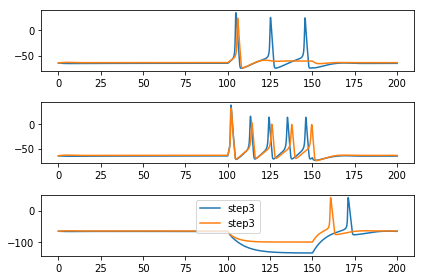

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload

import bluepyopt as bpop
import bluepyopt.ephys as ephys

morph = ephys.morphologies.NrnFileMorphology('ballandstick.swc')

somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')
basal_loc = ephys.locations.NrnSeclistLocation('basal', seclist_name='basal')

hh_mech = ephys.mechanisms.NrnMODMechanism(
        name='hh',
        suffix='hh',
        locations=[somatic_loc])

cm_param = ephys.parameters.NrnSectionParameter(
        name='cm',
        param_name='cm',
        value=1.0,
        locations=[somatic_loc],
        frozen=True)

gnabar_param = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh',
        param_name='gnabar_hh',
        locations=[somatic_loc],
        bounds=[0.05, 0.125],
        frozen=False)     
gkbar_param = ephys.parameters.NrnSectionParameter(
        name='gkbar_hh',
        param_name='gkbar_hh',
        bounds=[0.01, 0.05],
        locations=[somatic_loc],
        frozen=False)

gl_param = ephys.parameters.NrnSectionParameter(
        name='gl_hh',
        param_name='gl_hh',
        bounds=[1e-4, 5e-4],
        locations=[somatic_loc],
        frozen=False)

ballandstick_cell = ephys.models.CellModel(
        name='simple_cell',
        morph=morph,
        mechs=[hh_mech],
        params=[cm_param, gnabar_param, gkbar_param, gl_param])  

soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)

nrn = ephys.simulators.NrnSimulator()

sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.1), ('step2', 0.5), ('step3', -0.3)]:
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=amplitude,
                step_delay=100,
                step_duration=50,
                location=soma_loc,
                total_duration=200)
    rec = ephys.recordings.CompRecording(
            name='%s.soma.v' % protocol_name,
            location=soma_loc,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

def plot_responses(responses):
    plt.subplot(3,1,1)
    plt.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1')
    plt.subplot(3,1,2)
    plt.plot(responses['step2.soma.v']['time'], responses['step2.soma.v']['voltage'], label='step2')
    plt.subplot(3,1,3)
    plt.plot(responses['step3.soma.v']['time'], responses['step3.soma.v']['voltage'], label='step3')
    plt.legend()
    plt.tight_layout()

default_params = {'gnabar_hh': 0.1, 'gkbar_hh': 0.03, 'gl_hh': 0.0002}
responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=default_params, sim=nrn)
plot_responses(responses)

efel_feature_means_ex = {'step1': {'Spikecount': 1}, 'step2': {'Spikecount': 5}, 'step3': {'steady_state_voltage_stimend': -100}}
# efel_feature_means_ex = {'step1': {'AP_width': 1.3}, 'step2': {'AP_width': 1.6}} # solution
objectives_ex = []
features_ex = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means_ex[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * abs(mean))
        features_ex.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives_ex.append(objective)
        
score_calc_ex = ephys.objectivescalculators.ObjectivesCalculator(objectives_ex)

cell_evaluator_ex = ephys.evaluators.CellEvaluator(
        cell_model=ballandstick_cell,
        param_names=['gnabar_hh', 'gkbar_hh', 'gl_hh'],
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc_ex,
        sim=nrn)

optimisation_algorithm_ex = bpop.deapext.optimisations.IBEADEAPOptimisation(
        evaluator=cell_evaluator_ex,
        offspring_size = 10)

final_pop_ex, hall_of_fame_ex, logs_ex, hist_ex = optimisation_algorithm_ex.run(max_ngen=10)

best_ind_dict_ex = cell_evaluator_ex.param_dict(hall_of_fame_ex[0])
print('Best individual: ', best_ind_dict_ex)
print('Score: ', cell_evaluator_ex.evaluate_with_dicts(best_ind_dict_ex))

plot_responses(twostep_protocol.run(cell_model=ballandstick_cell, param_values=best_ind_dict_ex, sim=nrn))

Example response:
('Best individual: ', {'gl_hh': 0.00035516157265000304, 'gnabar_hh': 0.08174733955125979, 'gkbar_hh': 0.02972723144756631})
('Score: ', {'step2.Spikecount': 0.0, 'step3.steady_state_voltage_stimend': 0.17800933922072204, 'step1.Spikecount': 0.0})